# Modèle ResNet50
Utilisation d'un générateur d'images  

Pour ce test, nous avons sélectionné les 20 genres de champignons.  

Différents tests avec ce modèle :  
- 4000 vs 2000 images par classes  
- 10 vs 20 classes  
- Tests avec différentes valeurs de Learning rate dans l'optimizer Adam  
- Ajout des callbacks (sauvegarde du meilleur modèle, early stopping et ReduceLROnPlateau  

Les différents résultats obtenus ont été retranscrits dans le rapport de la semaine  

Les tests qui n'ont pas abouti (GapML à la place d'ImageDataGenerator) sont dans un autre notebook non publié pour le moment



In [16]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

## Chargement du csv contenant les chemins des images à utiliser sur le HDD
4000 liens url par classes  
Séparation jeu d'entrainement et de test à 20%

In [38]:
import pandas as pd
import pathlib

# Chargement du fichier
df = pd.read_csv ("20genus.csv", index_col=0)

# On ajoute le chemin où se trouve l'arborescence précédente (peut varier selon les personnes)
base_dir = './ChampImages2'
df["path"] = base_dir+df["path"]


In [18]:
df.head()

,Unnamed: 0.1,id,identifier_y,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,notreid
106,106,3022624752,https://files.plutof.ut.ee/public/large/80/6C/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius meinhardii,"Cortinarius meinhardii Bon, 1986",EE,58.02611,22.16833,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,106
108,108,3022625110,https://files.plutof.ut.ee/public/large/4B/5B/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius delibutus,"Cortinarius delibutus Fr., 1838",EE,58.02667,26.57722,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,108
109,109,3022625373,https://files.plutof.ut.ee/public/large/C9/A4/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius prasinus,"Cortinarius prasinus (Schaeff.) Fr., 1838",EE,58.02611,22.16833,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,109
110,110,3022625373,https://files.plutof.ut.ee/public/large/C4/51/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius prasinus,"Cortinarius prasinus (Schaeff.) Fr., 1838",EE,58.02611,22.16833,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,110
111,111,3022625785,https://files.plutof.ut.ee/public/large/19/E7/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius infractus,"Cortinarius infractus (Pers.) Fr., 1838",EE,58.75333,23.17167,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,111


In [19]:
df.genus.value_counts()

Cerioporus       11474
Amanita           7478
Mycena            7249
Russula           6971
Fomitopsis        6077
Lactarius         5415
Tricholoma        5294
Ganoderma         5134
Stereum           5121
Cortinarius       5000
Boletus           5000
Hypholoma         5000
Entoloma          5000
Fomes             5000
Hygrocybe         5000
Schizophyllum     5000
Trametes          5000
Auricularia       5000
Coprinellus       5000
Suillus           5000
Pleurotus         5000
Laetiporus        5000
Agaricus          4803
Coprinus          2919
Name: genus, dtype: int64

## On limite notre test à 10 classes et 4000 photos par classes
On augmentera encore la semaine prochaine

In [39]:
sample_per_classe = 2000

sub_c1 = df[df["genus"] == "Cerioporus"].sample(sample_per_classe)
sub_c2 = df[df["genus"] == "Amanita"].sample(sample_per_classe)
sub_c3 = df[df["genus"] == "Mycena"].sample(sample_per_classe)
sub_c4 = df[df["genus"] == "Russula"].sample(sample_per_classe)
sub_c5 = df[df["genus"] == "Fomitopsis"].sample(sample_per_classe)
sub_c6 = df[df["genus"] == "Lactarius"].sample(sample_per_classe)
sub_c7 = df[df["genus"] == "Tricholoma"].sample(sample_per_classe)
sub_c8 = df[df["genus"] == "Ganoderma"].sample(sample_per_classe)
sub_c9 = df[df["genus"] == "Stereum"].sample(sample_per_classe)
sub_c10 = df[df["genus"] == "Cortinarius"].sample(sample_per_classe)

sub_c11 = df[df["genus"] == "Boletus"].sample(sample_per_classe)
sub_c12 = df[df["genus"] == "Hypholoma"].sample(sample_per_classe)
sub_c13 = df[df["genus"] == "Entoloma"].sample(sample_per_classe)
sub_c14 = df[df["genus"] == "Fomes"].sample(sample_per_classe)
sub_c15 = df[df["genus"] == "Hygrocybe"].sample(sample_per_classe)
sub_c16 = df[df["genus"] == "Schizophyllum"].sample(sample_per_classe)
sub_c17 = df[df["genus"] == "Trametes"].sample(sample_per_classe)
sub_c18 = df[df["genus"] == "Auricularia"].sample(sample_per_classe)
sub_c19 = df[df["genus"] == "Coprinellus"].sample(sample_per_classe)
sub_c20 = df[df["genus"] == "Suillus"].sample(sample_per_classe)

data = pd.concat([sub_c1, sub_c2, sub_c3, sub_c4, sub_c5, sub_c6, sub_c7, sub_c8, sub_c9, sub_c10, 
                  sub_c11, sub_c12, sub_c13, sub_c14, sub_c15, sub_c16, sub_c17, sub_c18, sub_c19, sub_c20])

data

,Unnamed: 0.1,id,identifier_y,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,notreid
372507,397992,2252027070,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,CA,43.212412,-79.744628,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,397992
150475,175960,3124791986,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,US,39.812076,-85.186685,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,175960
689563,802690,1837766530,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,US,40.663111,-73.966264,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,802690
337112,362597,1838045523,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus leptocephalus,Cerioporus leptocephalus,US,37.906700,-122.254500,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,362597
591132,644517,2366138884,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,DE,52.127500,8.747084,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,644517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366307,391792,1802675090,https://inaturalist-open-data.s3.amazonaws.com...,Boletales,Suillaceae,Suillus,Suillus caerulescens,Suillus caerulescens,US,37.059807,-122.363540,True,./ChampImages2/Boletales/Suillaceae/Suillus/Su...,391792
315624,341109,3032170874,https://inaturalist-open-data.s3.amazonaws.com...,Boletales,Suillaceae,Suillus,Suillus granulatus,Suillus granulatus,US,38.051961,-122.871558,True,./ChampImages2/Boletales/Suillaceae/Suillus/Su...,341109
247215,272700,3018147252,https://inaturalist-open-data.s3.amazonaws.com...,Boletales,Suillaceae,Suillus,Suillus caerulescens,Suillus caerulescens,US,38.428643,-122.910278,True,./ChampImages2/Boletales/Suillaceae/Suillus/Su...,272700
81591,100781,2006065547,https://inaturalist-open-data.s3.amazonaws.com...,Boletales,Suillaceae,Suillus,Suillus pungens,Suillus pungens,US,36.570621,-121.766792,True,./ChampImages2/Boletales/Suillaceae/Suillus/Su...,100781


## Création des ensembles d'entrainement et de test

In [21]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)

data.head()

,Unnamed: 0.1,id,identifier_y,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,notreid
277353,302838,2242957840,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,US,40.292693,-74.724823,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,302838
64264,83454,3307235204,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,DK,55.366283,10.453690,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,83454
29875,49065,3112392272,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,US,39.367518,-77.058121,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,49065
192799,218284,2243018372,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,US,40.598020,-75.376617,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,218284
381059,406544,2242801016,https://inaturalist-open-data.s3.amazonaws.com...,Polyporales,Polyporaceae,Cerioporus,Cerioporus squamosus,Cerioporus squamosus,US,39.606363,-76.640687,True,./ChampImages2/Polyporales/Polyporaceae/Ceriop...,406544


## Test d'affichage de la première image du Data_Test 

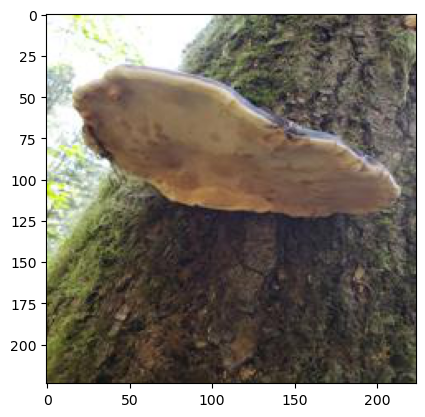

In [22]:
from tensorflow.keras.preprocessing import image

filename = data_test.path.iloc[0]

# A conserver pour d'autres tests rapides
#img = image.load_img('./Images/test/Agaricaceae/Chlorophyllum brunneum1866.jpg',target_size=(224,224))

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  


In [23]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False)

# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [24]:
# Entrainment depuis des images données dans un dataset
batch_size = 20
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                    directory = "",
                                                    x_col = "path",
                                                    y_col = "genus",
                                                    batch_size = batch_size,
                                                    class_mode = 'sparse', #"raw", #"'binary', #'sparse' ?
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                        directory="",
                                                        x_col = "path",
                                                        y_col = "genus",
                                                        batch_size = batch_size,
                                                        class_mode = 'sparse',
                                                        target_size = (224, 224))

Found 32000 validated image filenames belonging to 20 classes.
Found 8000 validated image filenames belonging to 20 classes.


## Elimination des fichiers corrompus sur le HDD
Nous avons pu constater que des fichiers corrompus faisaient planter les modèles dans l'itération précédente.  
Suite à un nettoyage en amont il ne doit plus sortir de nouveaux fichiers corrompus  

In [25]:
from PIL import Image
tab = train_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)
        
tab = validation_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)

## Création du modèle ResNet50 pré-entrainé avec ImageNet

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential

nb_classes = 20

base_model = ResNet50(input_shape=(224, 224,3), 
                      include_top=False, 
                      weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = nb_classes, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(), #"adam", #optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                   loss = 'sparse_categorical_crossentropy', #loss = 'binary_crossentropy', 
                   metrics = ['acc'])



In [31]:
import tensorflow as tf 

if tf.test.gpu_device_name():
    print('GPU détecté par défaut : {}'.format(tf.test.gpu_device_name()))
    device_name = "/GPU:0"
else:
    print("Pas de GPU disponible sur votre machine.")
    device_name = "/device:CPU:0"

GPU détecté par défaut : /device:GPU:0


In [21]:
from tensorflow.python.client import device_lib

def check_available_gpus():
    local_devices = device_lib.list_local_devices()
    gpu_names = [x.name for x in local_devices if x.device_type == 'DML']
    gpu_num = len(gpu_names)

    print('{0} GPUs are detected : {1}'.format(gpu_num, gpu_names))

    return gpu_num

check_available_gpus()

0 GPUs are detected : []


0

## Définition des callbacks de sauvegarde et d'early stopping 

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("resnet50_1.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq="epoch")

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=5, 
                      verbose=1, 
                      mode='auto')


reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=5,
                              cooldown=0,
                              min_lr=0.00001)


## Entrainement

In [35]:
history = model.fit(train_generator, 
                         validation_data = validation_generator, 
                         steps_per_epoch = len(data_train) // batch_size,
                         validation_steps= len(data_test) // batch_size,   
                         epochs = 50,
                   callbacks=[checkpoint, early, reduce_lr])

Epoch 1/50
1600/1600 [==============================] - 912s 568ms/step - loss: 1.9728 - acc: 0.3748 - val_loss: 1.5488 - val_acc: 0.4940

Epoch 00001: val_acc improved from -inf to 0.49400, saving model to resnet50_1.h5
Epoch 2/50
1600/1600 [==============================] - 918s 574ms/step - loss: 1.6970 - acc: 0.4565 - val_loss: 1.4173 - val_acc: 0.5405

Epoch 00002: val_acc improved from 0.49400 to 0.54050, saving model to resnet50_1.h5
Epoch 3/50
1600/1600 [==============================] - 1040s 650ms/step - loss: 1.6070 - acc: 0.4840 - val_loss: 1.3904 - val_acc: 0.5512

Epoch 00003: val_acc improved from 0.54050 to 0.55125, saving model to resnet50_1.h5
Epoch 4/50
1600/1600 [==============================] - 896s 560ms/step - loss: 1.5568 - acc: 0.5047 - val_loss: 1.3638 - val_acc: 0.5594

Epoch 00004: val_acc improved from 0.55125 to 0.55937, saving model to resnet50_1.h5
Epoch 5/50
1600/1600 [==============================] - 880s 550ms/step - loss: 1.5240 - acc: 0.5145 - val

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)               

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
On note un surapprentissage, la précision sur le test set étant significativement plus faible que sur le train set

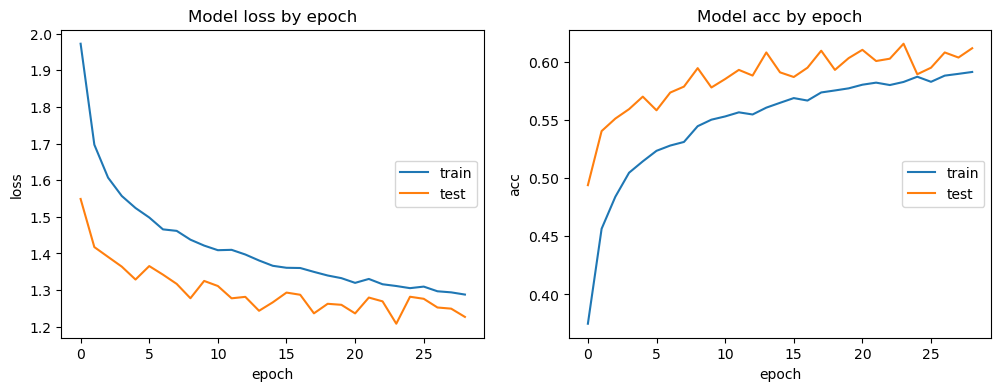

In [37]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 

On affiche les probabilités du champignon testé avec les 10 classes puis le nom de la classe choisie


In [31]:
#Récupération des classes
train_generator.get_classes(data_train, "genus")
labels = (train_generator.class_indices)
classes = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]

./ChampImages/Polyporales/Fomitopsidaceae/Phaeolus/Phaeolus schweinitzii/im249140.jpg


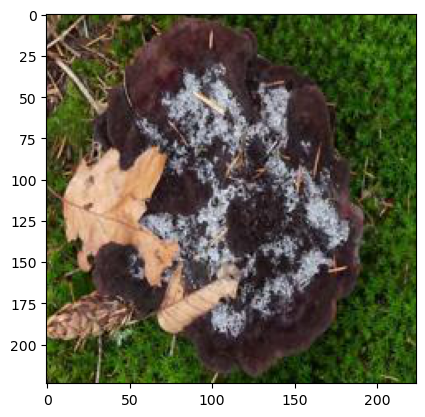

Probabilité pour les 10 classes : [[5.1740967e-03 2.9900851e-02 2.6900016e-03 3.3281378e-03 3.9839968e-03
  4.4844290e-03 4.3659896e-04 1.4308977e-02 9.0790731e-01 2.7785605e-02]]
Classe présentie : Phaeolus


In [32]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Polyporales/Phanerochaetaceae/Byssomerulius/Byssomerulius incarnatus/im1112268.jpg


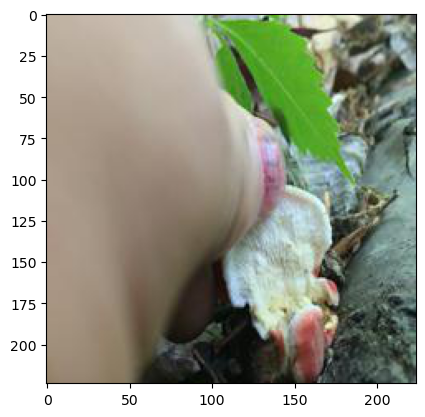

Probabilité pour les 10 classes : [[0.01602629 0.03790876 0.41713947 0.06090324 0.03806463 0.01952716
  0.37531662 0.01292575 0.01613686 0.00605125]]
Classe présentie : Auricularia


In [33]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Boletales/Paxillaceae/Paxillus/Paxillus involutus/im901638.jpg


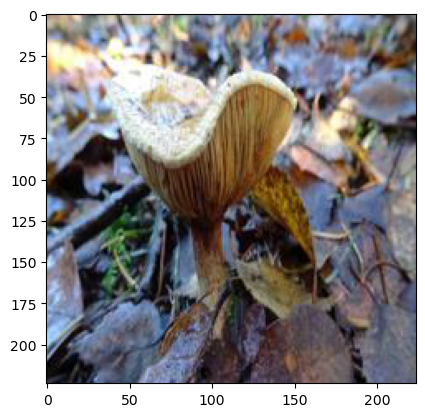

Probabilité pour les 10 classes : [[1.11373221e-04 1.95168902e-03 4.15641443e-05 3.56643500e-06
  1.55072466e-05 3.92316878e-02 6.27685367e-05 9.58443284e-01
  2.15175278e-05 1.17036245e-04]]
Classe présentie : Paxillus


In [34]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Boletales/Sclerodermataceae/Scleroderma/Scleroderma citrinum/im22403.jpg


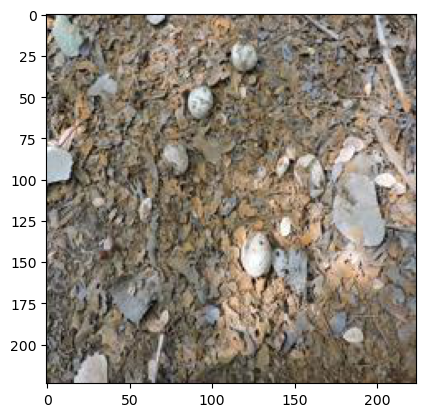

Probabilité pour les 10 classes : [[0.36567262 0.0426542  0.00138361 0.01119615 0.32266462 0.0042975
  0.14841476 0.00321408 0.0014857  0.09901683]]
Classe présentie : Agaricus


In [35]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])